In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.stats import truncnorm

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm
import time
import pdb
import argparse
import sys
from shapes_loader import *
from base_model import *
import tf_homo

DEVICE = 'cuda'

In [2]:
# parameter 
threshold = 0.4
config = dict()
config['aggregation'] = 'max' # 'sum'
config['num'] = 100 # how many homography adaptation to perform per image
config['patch_ratio'] = 0.85

# load in model
magic_leap_model = SuperPointNet().to(DEVICE)
model = torch.load('./Fri Nov  9 15:54:21 2018/e_405_a_10.9042.model').to(DEVICE)
magic_leap_model.load_state_dict(torch.load('superpoint_v1.pth'))
criterion = nn.Softmax(dim=1) #reduction='elementwise_sum')

# load in images
img_dir = '../test_coco/'
imgsList = os.listdir(img_dir)
clr_imgs = [Image.open(img_dir+img).resize((400,300),Image.ANTIALIAS) for img in imgsList]

net = model.eval()

a = {}
with torch.no_grad():    
    a = homography_adaptation(clr_imgs[0].convert('L'), net, config)
    a['prob_orig'], _ = net(torch.from_numpy(np.array(clr_imgs[0].convert('L'))).unsqueeze(0).unsqueeze(1).float().to(DEVICE))

print('prob shape:',a['prob'].shape)
print('images shape:',a['images'].shape)
print('counts shape:',a['counts'].shape)
print('patches shape:',len(a['patches']))

NameError: name 'homography_adaptation' is not defined

In [10]:
# test warp_point method
a = torch.zeros([1,3,3,2])
a[0,0,1,1] = 1
a[0,0,2,1] = 2
a[0,1,0,0] = 1
a[0,1,1,0] = 1
a[0,1,1,1] = 1
a[0,1,2,0] = 1
a[0,1,2,1] = 2
a[0,2,0,0] = 2
a[0,2,1,0] = 2
a[0,2,1,1] = 1
a[0,2,2,0] = 2
a[0,2,2,1] = 2
shape = torch.Tensor([2,2])

# sample homography
H,patch = sample_homography(shape)
# its inverse
invH = invert_homography(H)
# warp points
warped_a = warp_point(H,a)
# warp back
dewarped_a = warp_point(invH,warped_a)
print(dewarped_a)

tensor([[[[ 2.9137e-08, -7.2842e-09],
          [ 2.9137e-08,  1.0000e+00],
          [ 2.9137e-08,  2.0000e+00]],

         [[ 1.0000e+00, -1.3673e-08],
          [ 1.0000e+00,  1.0000e+00],
          [ 1.0000e+00,  2.0000e+00]],

         [[ 2.0000e+00, -1.2777e-08],
          [ 2.0000e+00,  1.0000e+00],
          [ 2.0000e+00,  2.0000e+00]]]])


In [7]:
def warp_point(homo, pts):
    """
    Warp batch of pts with a homography matrix H.
    
    INPUT: H: [[H_11,H_12,H_13,H_21,H_22,H_23,H_31,H_32,1]] as generated by sample homography
           pts: [B, H, W, 2] torch tensor
    OUTPUT: warped_pts: [B, H, W, 2]
    """
    B = pts.shape[0] # batch_sz
    H = pts.shape[1] # height
    W = pts.shape[2] # width
    pts = pts.view(B,-1,2) # B x P x 2
    P = pts.shape[1] # pt_num
    
    pts = torch.cat((pts,torch.ones(B,P,1)),dim=-1)
    pts = torch.transpose(pts,1,2) # B x 3 x P
    matHomo = flat2mat(homo).repeat(B,1,1) # B x 3 x 3
    
    res = torch.bmm(matHomo,pts) # B x 3 x P
    res = res/res[:,2,:].unsqueeze(1) # normalize by z
    
    return torch.transpose(res,1,2)[:,:,:-1].view(B,H,W,2)

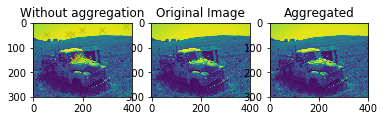

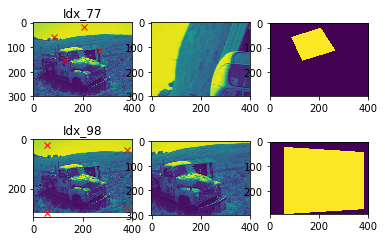

In [8]:
show_results(a,2)

In [6]:
def show_results(results, num_to_show):
    """
    show results from homography adaptation
    INPUT: output of homography adaptation
    """
    prob = results['prob']
    ori_prob = results['prob_orig']
    patches = results['patches']
    images = results['images']
    counts = results['counts'].squeeze(0).squeeze(0)

    # show aggregated results
    fig=plt.figure()
    # show original image
    fig.add_subplot(1, 3, 2, title='Original Image')
    plt.imshow(images[:,:,0])
    # show without aggregation
    fig.add_subplot(1, 3, 1, title='Without aggregation')
    plt.imshow(images[:,:,0]) 
    # inference
    ipt_sm_1 = criterion(ori_prob)
    ipt_sm_1 = ipt_sm_1[:,:-1,:,:]
    #find the max entry and confidence
    idx_conf_1, idx_locs_1 = ipt_sm_1.max(dim=1)
    idx_mask_1 = idx_conf_1 > threshold
    px = []
    py = []
    for x in range(prob.shape[2]):
        for y in range(prob.shape[3]):
            if idx_mask_1[0,x,y] == 1:
                #location in the image
                x_ = x*8 +(idx_locs_1[0,x,y]/8)
                y_ = y*8 + (idx_locs_1[0,x,y]%8)
                px.append(x_.item())
                py.append(y_.item())
    plt.plot(py,px,'xy')
    # show with aggregation
    fig.add_subplot(1, 3, 3, title='Aggregated')
    plt.imshow(images[:,:,0])
    # inference
    ipt_sm_1 = criterion(prob)
    ipt_sm_1 = ipt_sm_1[:,:-1,:,:]
    #find the max entry and confidence
    idx_conf_1, idx_locs_1 = ipt_sm_1.max(dim=1)
    idx_mask_1 = idx_conf_1 > threshold
    px = []
    py = []
    for x in range(prob.shape[2]):
        for y in range(prob.shape[3]):
            if idx_mask_1[0,x,y] == 1:
                #location in the image
                x_ = x*8 +(idx_locs_1[0,x,y]/8)
                y_ = y*8 + (idx_locs_1[0,x,y]%8)
                px.append(x_.item())
                py.append(y_.item())
    plt.plot(py,px,'xy')
    # show homography adaptation
    fig=plt.figure()
    for j in range(0,num_to_show):
        i = int(torch.randint(low=0,high=images.shape[2],size=(1,1)).item())
        # get px py
        px = patches[i][:,0].numpy()
        py = patches[i][:,1].numpy()
        # show gray
        fig.add_subplot(num_to_show, 3, j*3+1, title='Idx_'+str(i))
        plt.imshow(images[:,:,0]) 
        plt.plot(px,py,'xr')
        # show warped gray
        fig.add_subplot(num_to_show, 3, j*3+2)
        plt.imshow(images[:,:,i+1])
        # show counts
        fig.add_subplot(num_to_show, 3, j*3+3)
        plt.imshow(counts[:,:,i+1])

In [5]:
def homography_adaptation(image, net, config):
    """
    INPUT: image is a PIL image, grayscale, testing is of size (400,300)
           net is a torch model
           condif is a dict() with parameters
    OUTPUT: aggregated patches, probs, images, counts
            note that patches is a python list.
    """
    # remember the original image
    test = image
    # convert image to torch tensor
    image = torch.from_numpy(np.array(test))
    # get the shape
    shape = torch.Tensor([image.shape[0], image.shape[1]]).type(torch.FloatTensor)
    # inference on original image
    probs, _ = net(image.float().unsqueeze(0).unsqueeze(1).to(DEVICE))
    # get the dust_bin out first, later cat in
    dust_bin = probs[:,-1,:,:].unsqueeze(0).cpu()
    # global variable for aggregation, will be concat at last dimension
    probs_to_cat = probs[:,:-1,:,:].view(1, 1, probs.shape[2]*8, probs.shape[3]*8).unsqueeze(-1).cpu()
    counts = torch.ones(probs_to_cat.shape)
    images = image.unsqueeze(-1).cpu()
    patches = []
    # sample homography
    for i in range(config['num']):
        H, patch = sample_homography(shape) # H*[w;h;1] = [_;_;_] is a coner of the patch 
        inv_H = invert_homography(H)
        # get in numpy
        test_H = H[0].numpy()
        test_inv_H = inv_H[0].numpy()
        # apply homography on color scale and grayscale
        test_warped = test.transform(size=test.size, 
                             method=Image.PERSPECTIVE, 
                             data=test_H, 
                             resample=Image.BILINEAR)
        image_warped = torch.from_numpy(np.array(test_warped))
        # inference on the warped image
        ipt_patch, _ = net(image_warped.unsqueeze(0).unsqueeze(1).float().to(DEVICE))
        # aggregate the probablities:
        # Get rid of dust bin: 1 x 65 x 37 x 50 -> N x 64 x 37 x50 -> N x 1 x 296 x 400
        # apply warp to the patch and concatenate
        prob = ipt_patch[:,:-1,:,:].view(1, 1, ipt_patch.shape[2]*8, ipt_patch.shape[3]*8).unsqueeze(-1)
        # warp the mask to correct
        count = Image.new("L", (ipt_patch.shape[3]*8, ipt_patch.shape[2]*8), "white")
        count = count.transform(size=(ipt_patch.shape[3]*8, ipt_patch.shape[2]*8), 
                        method=Image.PERSPECTIVE, 
                        data=test_inv_H, 
                        resample=Image.NEAREST)
        # aggregate prob
        probs_to_cat = torch.cat((probs_to_cat,prob.cpu()),dim=-1)
        # aggregate counts
        counts = torch.cat((counts,
                            torch.from_numpy(np.array(count)).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).unsqueeze(-1)),
                           dim=-1)
        # aggregate image
        images = torch.cat((images,image_warped.unsqueeze(-1).cpu()),dim=-1)
        # aggregate patch
        patches += [patch.cpu()]
    
    # aggregation done 
    counts_sum = torch.sum(counts, dim=-1)
    max_prob,_ = torch.max(probs_to_cat, dim=-1)
    mean_prob = torch.sum(probs_to_cat, dim=-1) / counts_sum
    # check aggregation method
    if config['aggregation'] == 'max':
        probs = max_prob
    elif config['aggregation'] == 'sum':
        probs = mean_prob
    else:
        raise ValueError('Unkown aggregation method: {}'.format(config['aggregation']))
    # cat back the dust bin
    probs = probs.view(1,64,dust_bin.shape[2],dust_bin.shape[3])
    probs = torch.cat((probs,dust_bin),dim=1)
    
    return {'prob':probs, 'patches':patches, 'images':images, 'counts':counts}

In [4]:
def sample_homography(
        shape, perspective=True, scaling=True, rotation=True, translation=True,
        n_scales=5, n_angles=25, scaling_amplitude=0.5, perspective_amplitude_x=0.2,
        perspective_amplitude_y=0.2, patch_ratio=0.85, max_angle=1.57,
        allow_artifacts=False, translation_overflow=0.):
    """Sample a random valid homography.

    Computes the homography transformation between a random patch in the original image
    and a warped projection with the same image size.
    
    The returned homography will transform orginal image corners to patch corners.

    The original patch is initialized with a patch_ratio centered crop. It is
    iteratively projected, scaled, rotated and translated.

    Arguments:
        shape: A rank-2 `Tensor` specifying the height and width of the original image.
        perspective: A boolean that enables the perspective and affine transformations.
        scaling: A boolean that enables the random scaling of the patch.
        rotation: A boolean that enables the random rotation of the patch.
        translation: A boolean that enables the random translation of the patch.
        n_scales: The number of tentative scales that are sampled when scaling.
        n_angles: The number of tentatives angles that are sampled when rotating.
        scaling_amplitude: Controls the amount of scale.
        perspective_amplitude_x: Controls the perspective effect in x direction.
        perspective_amplitude_y: Controls the perspective effect in y direction.
        patch_ratio: Controls the size of the patches used to create the homography.
        max_angle: Maximum angle used in rotations.
        allow_artifacts: A boolean that enables artifacts when applying the homography.
        translation_overflow: Amount of border artifacts caused by translation.

    Returns:
        A `Tensor` of shape [[1, 8]] corresponding to the flattened homography transform. 
        Note that it is 2D
    """

    # Corners of the output image
    pts1 = torch.Tensor([[0., 0.], [0., 1.], [1., 1.], [1., 0.]])
    # Corners of the input patch
    margin = (1 - patch_ratio) / 2
    pts2 = margin + torch.Tensor([[0, 0], [0, patch_ratio],
                                 [patch_ratio, patch_ratio], [patch_ratio, 0]])
#     print('pts2 initially...:', pts2)
    
    # Random perspective and affine perturbations
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        # create truncated normal distribution
        perspective_displacement = truncated_normal(-perspective_amplitude_y, perspective_amplitude_y, perspective_amplitude_y/2)[0]
        h_displacement_left = truncated_normal(-perspective_amplitude_x, perspective_amplitude_x, perspective_amplitude_x/2)[0]
        h_displacement_right = truncated_normal(-perspective_amplitude_x, perspective_amplitude_x, perspective_amplitude_x/2)[0]
        pts2 += torch.Tensor([[h_displacement_left, perspective_displacement], [h_displacement_left, -perspective_displacement],
                              [h_displacement_right, perspective_displacement], [h_displacement_right, -perspective_displacement]])
#     print('pts2 after perspective...:', pts2)
    
    # Random scaling
    # sample several scales, check collision with borders, randomly pick a valid one
    if scaling:
        scales = torch.ones([1+n_scales])
        scales[:-1] = torch.from_numpy(truncated_normal(-scaling_amplitude, scaling_amplitude, scaling_amplitude/2, my_mean=1, sz=n_scales))
        center = torch.mean(pts2, dim=0, keepdim=True)
        scales = scales.unsqueeze(1).unsqueeze(1)
        scaled = (pts2-center).unsqueeze(0) * scales + center
    #     temp = (pts2-center).unsqueeze(0)
    #     print('center',center.shape)
    #     print('temp',temp.shape)
    #     print('scales', scales.shape)
    #     print('scaled', scaled)

        if allow_artifacts:
            valid = torch.arange(n_scales) # all scales are valid except scale=1
        else:
            scaled_boolean = ( (scaled >= 0.) & (scaled < 1.) )
            valid = ( (scaled_boolean).sum(dim=(1,2)) == 8 ).nonzero().squeeze(1) # get the index of valid
        # get the index
        idx = valid[torch.randint(low=0, high=6, size=(1,),dtype=torch.int32)[0]]
        pts2 = scaled[idx]
        
#     print('scale is:', scales[idx], 'center is:', center)
#     print("pts2 after scaling: ", pts2)

    # Random translation
    if translation:
        t_min, t_max = torch.min(pts2, dim=0), torch.min(1-pts2, dim=0)
        t_min = t_min[0]
        t_max = t_max[0]

        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow

#         print(torch.randn(1) * (t_max[0]+t_min[0]) - t_min[0])
#         print('t min',t_min)
#         print('t max',t_max)
#         print( torch.rand(1) * (t_max[1]+t_min[1]) - t_min[1] )
        temp = torch.Tensor([[torch.rand(1) * (t_max[0]+t_min[0]) - t_min[0],
                              torch.rand(1) * (t_max[1]+t_min[1]) - t_min[1]]])
        pts2 += temp
#     print("pts2 after translation: ",pts2)
#     print("The translation is: ", temp)

    # Random rotation
    # sample several rotations, check collision with borders, randomly pick a valid one
    if rotation:
        # sample angles
        angles = torch.linspace(-max_angle, max_angle, n_angles)
        angles = torch.cat((angles, torch.zeros(1)))
        # get rotation matrix
        rot_mat = torch.t(torch.cat([torch.from_numpy(np.cos(angles.numpy())), 
                                     torch.from_numpy(-np.sin(angles.numpy())),
                                     torch.from_numpy(np.sin(angles.numpy())),
                                     torch.from_numpy(np.cos(angles.numpy()))]).view(4,-1)).view(-1,2,2)
        # get center of rotation
        center = torch.mean(pts2, dim=0, keepdim=True)
        # apply rotation
        rotated = torch.matmul((pts2-center).unsqueeze(0).repeat(n_angles+1,1,1), rot_mat) + center

        if allow_artifacts:
            valid = torch.arange(n_angles)  # all angles are valid, except angle=0
        else:
            rotated_boolean = ( (rotated >= 0.) & (rotated < 1.) )
            valid = ( rotated_boolean.sum(dim=(1,2)) == 8 ).nonzero()#.squeeze(1) # get the index of valid
        # get the index
        idx = valid[torch.randint(low=0, high=valid.shape[0], size=(1,), dtype=torch.int32)[0]]
        pts2 = rotated[idx].squeeze(0)
#     print('pts2 after rotation:',pts2)
#     print('The rotation angle is:',angles[idx])
#     print('The rotation matrix is:',rot_mat[idx])

    # Rescale to actual size
    pts1 = pts1 * torch.from_numpy(np.flip(shape.numpy(),0).copy()) # different convention [y, x]
    pts2 = pts2 * torch.from_numpy(np.flip(shape.numpy(),0).copy()) # different convention [y, x]
#     print('unsq pts1', pts1)
#     print('unsq pts2', pts2)
    
    # cv2 to estimate
    [h, _] = cv2.findHomography(pts1.numpy(), pts2.numpy())
    homography = torch.from_numpy(h.flatten()[0:-1]).unsqueeze(0).type(torch.FloatTensor)

#     # LS to estimate a H from 4 point pairs: AH = p
#     def ax(p, q): return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]
#     def ay(p, q): return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

#     a_mat = torch.FloatTensor([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)])
#     p_mat = torch.t(torch.FloatTensor([[pts2[i][j] for i in range(4) for j in range(2)]]))
#     homography = torch.t(torch.from_numpy(np.linalg.lstsq(a_mat, p_mat)[0]))
    return homography, pts2

# # test homography sampling
# homography = sample_homography(shape)

# homo = flat2mat(homography)
# invHomo = flat2mat(invert_homography(homography))

# res = torch.matmul(homo, torch.Tensor([0.,300.,1])).squeeze(0)
# res = res/res[2]
# print(res)
# res = torch.matmul(invHomo, res).squeeze(0)
# res = res/res[2]
# print(res)

In [3]:
def truncated_normal(myclip_a, myclip_b, my_std, my_mean=0., sz=1):
    """
    Generate random numbers from a truncated normal distribution
    """
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm.rvs(a, b, my_mean, my_std, size=sz)

def invert_homography(H):
    """
    Computes the inverse transformation for a flattened homography transformation.
    """
    matH = flat2mat(H)
    invH = torch.cat([torch.inverse(matH[i,:,:]) for i in range(matH.shape[0])]).view(matH.shape[0],3,3)
    return mat2flat(invH)

def flat2mat(H):
    """
    Converts a flattened homography with shape '[N, 8]' to its
    corresponding homography matrix with shape '[N, 3, 3]'.
    """
    return torch.reshape(torch.cat((H, torch.ones(H.shape[0],1)), dim=1), [-1,3,3])

def mat2flat(H):
    """
    Converts homography matrix with shape '[N, 3, 3]' to its
    flattened homography with shape '[N, 8]'.
    """
    H = torch.reshape(H, [-1, 9])
    return (H / H[:, 8:9])[:, :8]

# # unit test
# H = torch.ones([10,8])*64
# matH = flat2mat(H)
# flatH = mat2flat(matH)
# print(H)
# print(flatH)

# H = torch.ones([2,8])
# temp = torch.Tensor([1, 0, 3, 2, 1, -1, 4, 2, 4])/4
# H[0,:] = temp[:8]
# H[1,:] = temp[:8]

# print(H)
# print(invert_homography(H))